# Vinicius Augusto de Souza - RA: 1997530

-------------------------------------------------------------------------------------------------------------------------------

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import os

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
epochs = 100 # quantidade de vezes a ser executado o algoritmo, uma epoch é quanto todo o conjunto de treino foi utilizado
batch = 32 # número de amostras que será carregado a cada execução

In [3]:
#carrega o modelo da ResNet50V2 com os pesos aprendidos no treino da ImageNet sem a camada densa (include_top=False)

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False)

In [4]:
#O restante do modelo e suas camadas são discutidos a seguir
#x recebe o final da ResNet50V2

x=base_model.output

In [5]:
#Nova configuração para o modelo

#adiciona apos x uma camada AveragePooling2D e atribui este no a x novamente (logo x e o topo novamente)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#adiciona apos x uma camada densa com 32 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(128,activation='relu')(x)

#adiciona apos x uma camada densa com 64 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(64,activation='relu')(x)

#adiciona apos x uma camada densa com 128 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(32,activation='relu')(x)

#adiciona após x os neurônios que devem ser utilizados, nesse caso foram desligados 20% dos neuronios
x=tf.keras.layers.Dropout(0.2)(x)

#adiciona apos x uma camada densa com 7 neuronios (sete classes) com funcao de ativacao softmax (distribuicao de probabilidade). Atribui este no a preds
preds=tf.keras.layers.Dense(7,activation='softmax')(x)

#definindo modelo final
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

#mostrando modelo final e sua estrutura
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
#congelando os neuronios já treinados na ImageNet, queremos retreinar somente a ultima camada
for l in model.layers:
    if l.name.split('_')[0] != 'dense':
        l.trainable=False
    else:
        l.trainable=True

In [7]:
#iniciando objeto que apanhara todas as imagens de treino, processando as imagens com o metodo da ResNet50V2
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

#iniciando objeto que apanhara todas as imagens de teste, processando as imagens com o metodo da ResNet50V2
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

In [8]:
# Stop training when a monitored metric has stopped improving.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [9]:
#CARREGANDO PRÓPRIO DATASET PARA USO

#definindo gerador de imagens de treino
train_generator = train_data_gen.flow_from_directory('data_tt_g/train',
                                                 target_size=(128, 128), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

#definindo gerador de imagens de teste
test_generator = test_data_gen.flow_from_directory('data_tt_g/test',
                                                 target_size=(128, 128), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 731 images belonging to 7 classes.
Found 186 images belonging to 7 classes.


In [10]:
lr = tf.keras.optimizers.Adam(learning_rate=0.001)#estabelecendo taxa de otimização

model.compile(optimizer=lr, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#definicao dos steps
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

In [12]:
#treinando e testando o modelo
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=epochs,
                   validation_data=test_generator,
                   validation_steps=step_size_test,
                   callbacks=[callback])

c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
22/22 [==============================] - 31s 1s/step - loss: 2.0111 - accuracy: 0.2404 - val_loss: 1.4478 - val_accuracy: 0.4062
Epoch 2/100
22/22 [==============================] - 26s 1s/step - loss: 1.2570 - accuracy: 0.5022 - val_loss: 1.2187 - val_accuracy: 0.5125
Epoch 3/100
22/22 [==============================] - 26s 1s/step - loss: 1.0073 - accuracy: 0.6290 - val_loss: 1.1454 - val_accuracy: 0.5437
Epoch 4/100
22/22 [==============================] - 26s 1s/step - loss: 0.8764 - accuracy: 0.6534 - val_loss: 1.1931 - val_accuracy: 0.5063
Epoch 5/100
22/22 [==============================] - 25s 1s/step - loss: 0.6899 - accuracy: 0.7463 - val_loss: 1.0970 - val_accuracy: 0.5813
Epoch 6/100
22/22 [==============================] - 25s 1s/step - loss: 0.5515 - accuracy: 0.8150 - val_loss: 1.1136 - val_accuracy: 0.6125
Epoch 7/100
22/22 [==============================] - 25s 1s/step - loss: 0.4712 - accuracy: 0.8468 - val_loss: 1.2677 - val_accuracy: 0.5813
Epoch 8/100
2

Epoch 59/100
22/22 [==============================] - 25s 1s/step - loss: 0.0652 - accuracy: 0.9731 - val_loss: 3.0456 - val_accuracy: 0.5562
Epoch 60/100
22/22 [==============================] - 26s 1s/step - loss: 0.0416 - accuracy: 0.9854 - val_loss: 2.3670 - val_accuracy: 0.5625
Epoch 61/100
22/22 [==============================] - 26s 1s/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 3.2335 - val_accuracy: 0.5562
Epoch 62/100
22/22 [==============================] - 26s 1s/step - loss: 0.0402 - accuracy: 0.9884 - val_loss: 2.4878 - val_accuracy: 0.5625


In [13]:
#Avaliando o modelo
loss_train, train_acc = model.evaluate_generator(train_generator, steps=step_size_train)
loss_test, test_acc = model.evaluate_generator(test_generator, steps=step_size_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 0.997, Test: 0.562


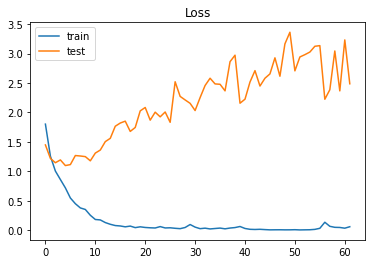

In [14]:
#Apresentando resultados em graficos
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

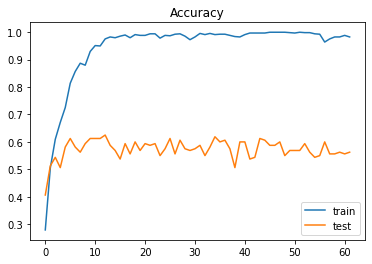

In [15]:
# Criando graficos para visualização dos resultados
print()
print()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [16]:
print('Criando classificações..')
labels = os.listdir('Database')
print('Rótulos', labels)
#criando estruturas para métricas de avaliação, processo um pouco mais demorado
Y_pred = model.predict_generator(test_generator)
print('Preds Created')
y_pred = np.argmax(Y_pred, axis=1)
print('Preds 1D created')

Criando classificações..
Rótulos ['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_columnar', 'normal_intermediate', 'normal_superficiel', 'severe_dysplastic']


c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Preds Created
Preds 1D created


----------------CLASSIFICATION--------------
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.17      0.17      0.17        30
   light_dysplastic       0.24      0.22      0.23        37
moderate_dysplastic       0.18      0.13      0.15        30
    normal_columnar       0.08      0.10      0.09        20
normal_intermediate       0.00      0.00      0.00        14
 normal_superficiel       0.08      0.07      0.07        15
  severe_dysplastic       0.20      0.25      0.22        40

           accuracy                           0.16       186
          macro avg       0.14      0.13      0.13       186
       weighted avg       0.16      0.16      0.16       186



<AxesSubplot:>

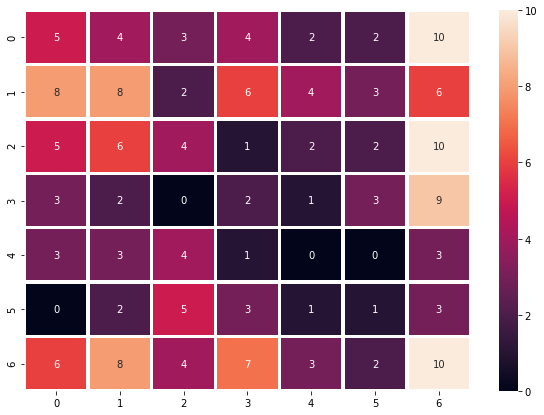

In [17]:
classification = classification_report(test_generator.classes, y_pred, target_names=labels)
print('----------------CLASSIFICATION--------------')
print(classification)
matrix = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidths=2.5)